# 🚖 Ride Revenue Recovery – Estimating Lost Revenue in Ride-Hailing

## Objective: Estimate and recover revenue lost due to unmet demand (with a focus on cancellations) in ride-hailing services using statistical imputation and Monte Carlo simulations.

### Problem Statement Formulation:

 Unmet demand in ride-hailing leads to significant revenue loss, but the challenge lies in understanding where this loss comes from and how much of it can realistically be recovered. The key questions were:

- How much revenue is lost due to unmet demand?
- Which segments contribute the most to this loss?
- Where should interventions be prioritized for maximum impact?


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

In [ ]:
file_path = r"C:\Projects\Uber\data\raw\ncr_ride_bookings.csv"
df = pd.read_csv(file_path, encoding="utf-8", parse_dates= True)
df.head()

### Analysis of Demand patterns



### Demand patterns by Month, Day of week, hourly

Aim: To find the most statistically significant granularity 

Approach:

- Analyse and visualise the trends by month, day of week and hour of day by count of total bookings.
- Significance test: Chi-Sqaure test to quantify the statistical significance of changes through time

In [ ]:
# Create datetime column
df["request_datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")

# Drop rows where datetime couldn't be parsed
df = df.dropna(subset=["request_datetime"])

# Sort chronologically
df = df.sort_values("request_datetime").reset_index(drop=True)

df["month"] = df["request_datetime"].dt.to_period("M")
df["day_of_week"] = df["request_datetime"].dt.day_name()
df["hour"] = df["request_datetime"].dt.hour


In [ ]:
# import plotly.io as pio
# pio.renderers.default = "browser"

# Monthly aggregation
monthly = df.groupby(df["request_datetime"].dt.to_period("M")).size().reset_index(name="bookings")
monthly["month"] = monthly["request_datetime"].astype(str)

# Interactive line chart
fig = px.line(
    monthly, 
    x="month", 
    y="bookings", 
    markers=True, 
    title="Monthly Booking Trends",
    template="plotly_white"  # sleek B/W theme
)
fig.update_traces(marker=dict(size=8), line=dict(width=2))


![Booking Trends](newplot.png)

In [ ]:
dow = df.groupby(df["request_datetime"].dt.day_name()).size().reset_index(name="bookings")
dow["day_of_week"] = pd.Categorical(
    dow["request_datetime"], 
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], 
    ordered=True
)

fig = px.line(
    dow, 
    x="day_of_week", 
    y="bookings", 
    title="Bookings by Day of Week",
    template="plotly_white"
)

fig.show()

![Booking Trends](dayofweek.png)

In [ ]:

hourly = df.groupby(df["request_datetime"].dt.hour).size().reset_index(name="bookings")

fig = px.line(
    hourly, 
    x="request_datetime", 
    y="bookings", 
    markers=True,
    title="Bookings by Hour of Day",
    template="plotly_white"
)
fig.update_traces(marker=dict(size=8), line=dict(width=2))
fig.show()

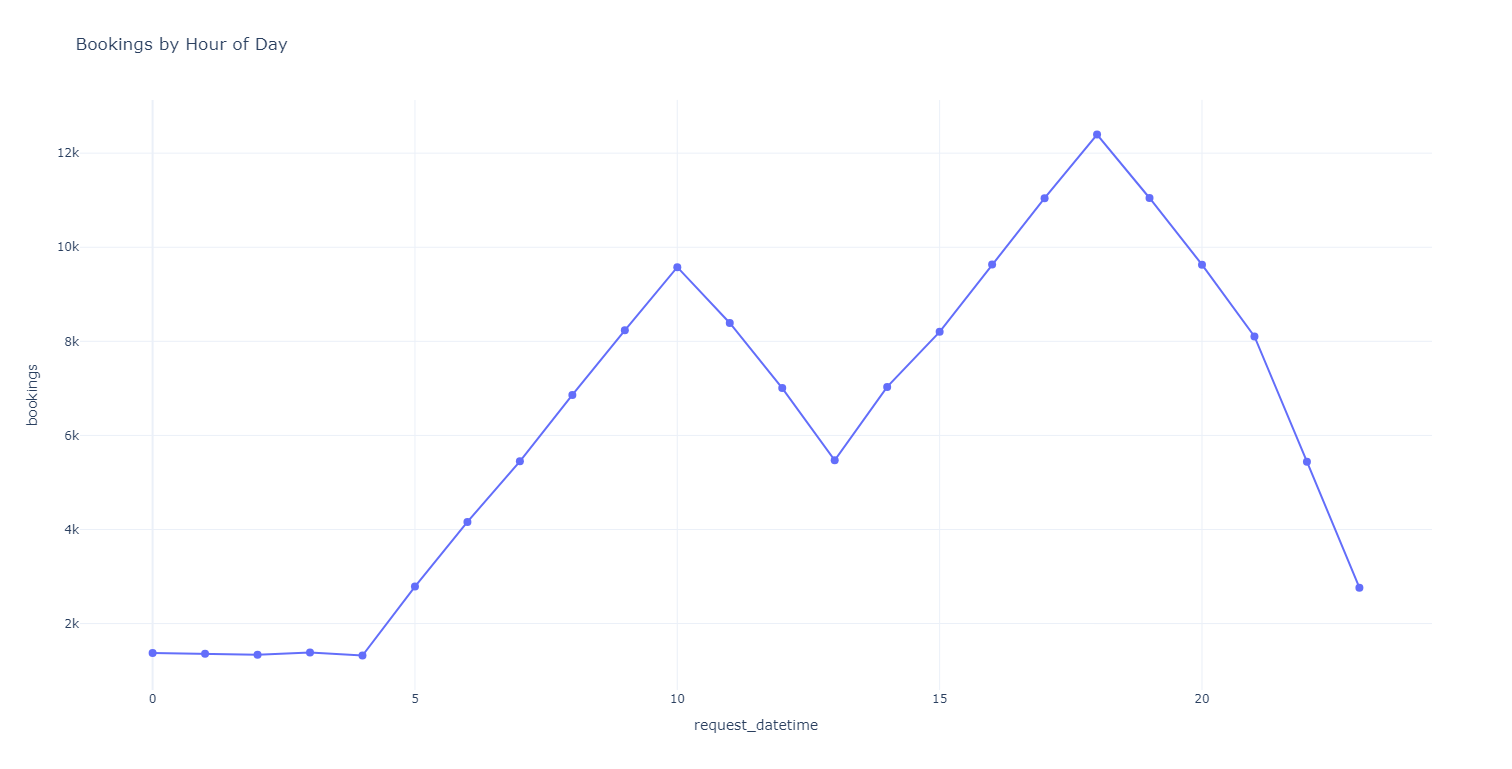

### APPROACH

- Select Granularity – Chi-Square tests to determine the level of granularity where variability is highest, ensuring deeper insights.

- Quantify Loss – Estimate total revenue loss and break it down by segment.

- Identify Key Contributors – Measure each segment’s share of loss and flag primary contributors (≥50% threshold).

- Drill Down into Hotspots – Segment contributors further and identify high-impact hotspots for immediate intervention.

- Estimate Recovery Potential – Calculate recoverable loss from interventions and project daily/hourly revenue uplift.


## Testing Statistical Significance of different granularities.

The purpose of selecting a granualrity is maximising data signal. The granularity at which the variances are explained the highest is the appropriate granularity to work with.

Approach: performing Chi2 test at month, day and hour of day. The threshold is set at p-value=0.05.

In [ ]:

import scipy.stats as stats

def deviation_analysis(df, time_col, time_labels=None, title=""):
    """
    Create % deviation from mean plot with significance test.
    
    Args:
        df (pd.DataFrame): dataframe with request_datetime column
        time_col (str): granularity - "day_of_week", "hour", or "month"
        time_labels (list): optional ordered labels for x-axis
        title (str): chart title
    
    Returns:
        fig (plotly Figure), chi2, p
    """
    # Extract relevant time column
    if time_col == "day_of_week":
        df["temp"] = df["request_datetime"].dt.day_name()
        if not time_labels:
            time_labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    elif time_col == "hour":
        df["temp"] = df["request_datetime"].dt.hour
        if not time_labels:
            time_labels = list(range(24))
    elif time_col == "month":
        df["temp"] = df["request_datetime"].dt.month_name()
        if not time_labels:
            time_labels = ["January","February","March","April","May","June",
                           "July","August","September","October","November","December"]
    else:
        raise ValueError("Invalid time_col. Choose from: day_of_week, hour, month")
    
    # Count values
    counts = df["temp"].value_counts().reindex(time_labels).fillna(0)
    
    # Calculate deviation
    mean_val = counts.mean()
    deviation = ((counts - mean_val) / mean_val) * 100
    
    # Build dataframe
    dev_df = pd.DataFrame({
        time_col: deviation.index,
        "% Deviation": deviation.values
    })
    dev_df["Category"] = np.where(dev_df["% Deviation"] >= 0, "Above Mean", "Below Mean")
    
    # Chi-square test
    chi2, p = stats.chisquare(counts)
    
    # Plot
    fig = px.bar(
        dev_df,
        x=time_col,
        y="% Deviation",
        color="Category",
        color_discrete_map={"Above Mean": "green", "Below Mean": "red"},
        text="% Deviation",
        template="plotly_white",
        title=title
    )
    fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
    fig.update_layout(showlegend=False, yaxis_title="% Deviation from Mean")
    
    return fig, chi2, p


In [ ]:


from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Generate individual figures
fig_dow, chi2_dow, p_dow = deviation_analysis(df, time_col="day_of_week", title="")
fig_hour, chi2_hour, p_hour = deviation_analysis(df, time_col="hour", title="")
fig_month, chi2_month, p_month = deviation_analysis(df, time_col="month", title="")

# Create subplot container (3 rows, 1 column)
combined_fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        f"Day of Week (Chi2={chi2_dow:.2f}, p={p_dow:.5f})",
        f"Hour of Day (Chi2={chi2_hour:.2f}, p={p_hour:.5f})",
        f"Month (Chi2={chi2_month:.2f}, p={p_month:.5f})"
    ]
)

# Add traces from each figure into the combined one
for trace in fig_dow.data:
    combined_fig.add_trace(trace, row=1, col=1)

for trace in fig_hour.data:
    combined_fig.add_trace(trace, row=2, col=1)

for trace in fig_month.data:
    combined_fig.add_trace(trace, row=3, col=1)

# Update layout
combined_fig.update_layout(
    height=1200, width=900,
    showlegend=False,
    template="plotly_white"
)

combined_fig.show()


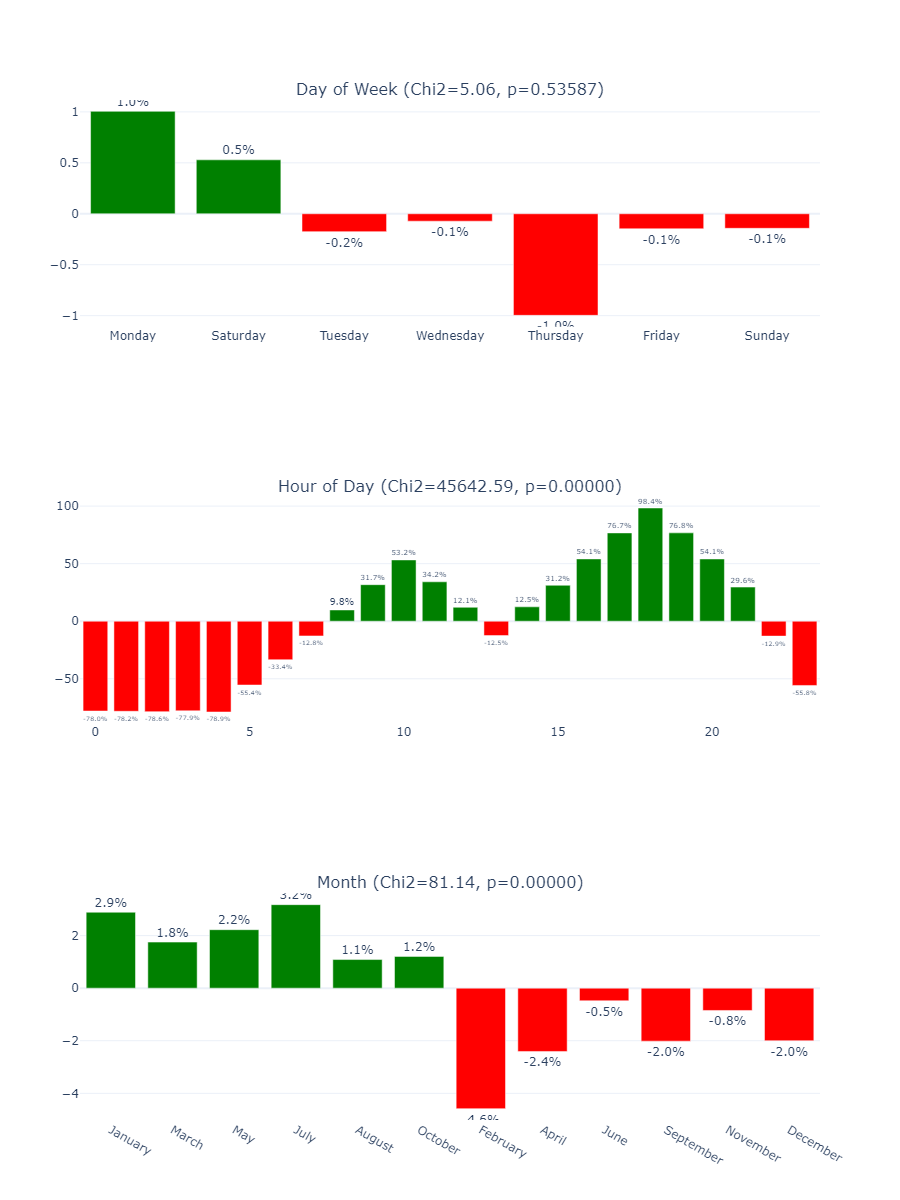

### Key Insights

Hourly patterns exhibit the strongest deviations from the mean. The Chi-square test (χ² ≈ 4,500, p < 0.001) confirms that booking volumes vary significantly across different hours of the day.

Implication: Demand–supply analysis should be anchored at the hourly level, since this is where the most pronounced and statistically significant patterns emerge.

Next step: Subsequent deep dives (e.g., unmet demand, cancellations, vehicle type performance) will therefore be evaluated with hour-of-day granularity to capture peak stress periods and operational gaps.

## An Overview of Unmet Demand:

- What percentage of demand is unmet? 
- What are the primary contributors of unmet demand?

In [ ]:
# Step 1: Standardize status column
df['Booking Status'] = df['Booking Status'].str.lower().str.strip()

# Step 2: Define categories
unmet_status = ['no driver found', 'cancelled by driver', 'incomplete', 'cancelled by customer']

# Step 3: Calculate unmet demand
total_bookings = len(df)
unmet_bookings = df[df['Booking Status'].isin(unmet_status)].shape[0]
completed_bookings = df[df['Booking Status'] == 'completed'].shape[0]

unmet_rate = (unmet_bookings / total_bookings) * 100

print(f"Total Bookings: {total_bookings}")
print(f"Completed Bookings: {completed_bookings}")
print(f"Unmet Bookings: {unmet_bookings}")
print(f"Unmet Demand Rate: {unmet_rate:.2f}%")

In [ ]:
reason_counts = (
    df[df['Booking Status'].isin(unmet_status)]
    ['Booking Status']
    .value_counts(normalize=True) * 100
).reset_index()
reason_counts.columns = ['Reason', 'Percentage']

print(reason_counts)

### INSIGHTS

- Driver cancellation accounts for 47% of total unmet demand in terms of booking numbers. 
- Demand gap (no available drivers) account for ~18%.
- Customer cancellation accounted for 18%
- Approximately 19% of the unmet demand is caused due to incomplete rides.




## Estimate of revenue loss due to unmet demand

In [ ]:
# Standardize column names for convenience
df = df.rename(columns={"Booking Status": "Status", "Booking Value": "RideValue"})

# Mark lost revenue only for unsuccessful rides
df["lost_revenue"] = df.apply(
    lambda x: x["RideValue"] if str(x["Status"]).lower() in 
              ["cancelled by driver", "no driver found", "incomplete", "cancelled by customer"] 
              else 0, 
    axis=1
)

# Totals
total_potential = df["RideValue"].sum()
total_lost = df["lost_revenue"].sum()
loss_pct = (total_lost / total_potential) * 100

print(f"Total Potential Revenue: ₹{total_potential:,.0f}")
print(f"Lost Revenue: ₹{total_lost:,.0f} ({loss_pct:.2f}%)")

### Approach for Estimating Lost Revenue

Since fare information is not captured for rides that were cancelled (by driver or customer) or unfulfilled due to lack of service availability, we cannot directly measure the associated revenue loss. To address this gap, we approximate the lost revenue using statistical characteristics of the observed (completed) rides:

Mean Fare (μ): Provides the baseline average ride value.

Standard Deviation (σ): Quantifies variability in fares, highlighting the extent of spread around the mean.

Coefficient of Variation (CV = σ / μ): Normalizes variability relative to the mean, useful for assessing revenue estimation stability.

By applying the mean fare as a proxy for missing values, and considering the spread (σ, CV) as adjustment factors, we can generate a more realistic estimate of the revenue impact from unmet rides. This ensures our projections reflect both central tendency and variability in ride values, rather than relying on a simplistic average.


In [ ]:
completed = df[df["Status"].str.lower() == "completed"]["RideValue"]

mean_fare = completed.mean()
median_fare = completed.median()
std_fare = completed.std()
cv_fare = std_fare / mean_fare  # coefficient of variation

print(f"Mean Fare: ₹{mean_fare:,.2f}")
print(f"Median Fare: ₹{median_fare:,.2f}")
print(f"Std Dev Fare: ₹{std_fare:,.2f}")
print(f"CV: {cv_fare:.2f}")

## Statistical Insight on Fare Distribution

The distribution of ride fares exhibits substantial variability. While the mean fare is ₹508.18, the median fare of ₹414.00 indicates a right-skewed distribution, with a subset of higher-value rides pulling the average upward.

The standard deviation of ₹396.06 is relatively large compared to the mean, which is further reflected in the coefficient of variation (CV = 0.78). A CV of this magnitude suggests that ride values are highly dispersed, with considerable inconsistency across individual trips.

From a business perspective, this variability implies that using a simple mean-based estimate for lost revenue could overstate the true impact, particularly given the skewed nature of the fare distribution. Adjustments such as applying the median fare or stratifying estimates by ride type, distance, or time of day would yield more robust and representative estimates of lost revenue.

In [ ]:
# Drop missing values from RideValue
ride_values = df["RideValue"].dropna()

# Calculate stats
mean_val = ride_values.mean()
median_val = ride_values.median()

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [3, 1]})

# Histogram
axes[0].hist(ride_values, bins=40, edgecolor="black", alpha=0.7)
axes[0].axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean: ₹{mean_val:.0f}")
axes[0].axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median: ₹{median_val:.0f}")
axes[0].set_title("Distribution of Ride Fares", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Fare (₹)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Boxplot
axes[1].boxplot(ride_values, vert=False, patch_artist=True,
                boxprops=dict(facecolor="lightblue", color="navy"),
                medianprops=dict(color="red", linewidth=2))
axes[1].set_xlabel("Fare (₹)")

plt.tight_layout()
plt.show()

## Lost Revenue Estimation (Monte Carlo Simulation)


In [ ]:
# Number of unmet rides
unmet_count = df[df["Status"].str.lower().isin(
    ["cancelled by driver","no driver found","incomplete","cancelled by customer"]
)].shape[0]

# Monte Carlo simulation (100000 runs)
simulations = []
for _ in range(100000):
    samples = np.random.choice(completed, size=unmet_count, replace=True)
    simulations.append(samples.sum())

simulations = np.array(simulations)

# Results
mean_estimate = simulations.mean()
ci_lower = np.percentile(simulations, 2.5)
ci_upper = np.percentile(simulations, 97.5)

print(f"Estimated Lost Revenue: ₹{mean_estimate:,.0f}")
print(f"95% Confidence Interval: ₹{ci_lower:,.0f} – ₹{ci_upper:,.0f}")


Using 100,000 resampling runs of completed rides as a proxy for cancelled/no-driver rides, the expected lost revenue is estimated at ₹28.97M.

The 95% confidence interval ranges between ₹28.78M and ₹29.15M, indicating that the estimate is stable and statistically robust.

Given that cancellations and driver unavailability represent ~38% of total demand, this lost revenue highlights a material leakage in supply-demand matching, warranting interventions in driver retention, fleet balancing, and demand prediction.

- Total Potential Revenue= INR 76M

- Total Revenue from 'Completed' rides= INR 47M
- Total lost Revenue from unfulfilled requests= INR 29M

## Estimated Contribution of primary 'Drivers' towards Revenue loss

- What percentage of Revenue loss is caused by 'No Driver found', 'Driver cancellation', 'Incomplete rides', 'Customer Cancellation', individually.

This analysis would enable a deeper understanding of how each channel is contributing towards the loss in revenue. After that,each key drivers would be investigated at 3 angles: Vehicle type, Hourly unmet demand and unmet demand by location.

Approach: 

Use Monte-Carlo simulation by segments of loss drivers to estimate the revenue lost by each and the percentage contribution towards total loss, based on the distribution pattern from 'Completed rides'.

The simulation mean will then be validated against 'Incomplete' ride values, for which, the ground truth is available.

### Contribution towards revenue loss for each 'driver'

In [ ]:


# Completed fare distribution
completed_fares = df.loc[df["Status"].str.lower()=="completed", "RideValue"].dropna().values

# Unmet counts by driver
drivers = {
    "Driver Cancellation": ["cancelled by driver"],
    "No Driver Found": ["no driver found"],
    "Incomplete": ["incomplete"],
    "Customer Cancellation": ["cancelled by customer"]
}
unmet_counts = {
    name: df["Status"].str.lower().isin(codes).sum()
    for name, codes in drivers.items()
}

n_sims = 10000
rng = np.random.default_rng(42)  # fixed seed for reproducibility

# Arrays to hold simulated losses
sim_losses = {name: np.zeros(n_sims) for name in unmet_counts}
sim_total = np.zeros(n_sims)

for i in range(n_sims):
    run_total = 0.0
    for name, cnt in unmet_counts.items():
        if cnt > 0:
            samples = rng.choice(completed_fares, size=cnt, replace=True)
            loss = samples.sum()
        else:
            loss = 0.0
        sim_losses[name][i] = loss
        run_total += loss
    sim_total[i] = run_total

# Summaries
summary = []
for name, arr in sim_losses.items():
    summary.append({
        "Driver of Loss": name,
        "Unmet Rides": unmet_counts[name],
        "Mean Loss (₹)": arr.mean(),
        "CI 2.5% (₹)": np.percentile(arr, 2.5),
        "CI 97.5% (₹)": np.percentile(arr, 97.5),
        "Share of Total (%)": 100 * arr.mean() / sim_total.mean() if sim_total.mean() else 0
    })
summary = pd.DataFrame(summary).sort_values("Mean Loss (₹)", ascending=False)

total_row = pd.DataFrame([{
    "Driver of Loss": "TOTAL",
    "Unmet Rides": sum(unmet_counts.values()),
    "Mean Loss (₹)": sim_total.mean(),
    "CI 2.5% (₹)": np.percentile(sim_total, 2.5),
    "CI 97.5% (₹)": np.percentile(sim_total, 97.5),
    "Share of Total (%)": 100.0
}])

summary = pd.concat([summary, total_row], ignore_index=True)
print(summary)


In [ ]:
drivers = list(results.keys())
means = [res["mean_loss"] for res in results.values()]
lowers = [res["ci_lower"] for res in results.values()]
uppers = [res["ci_upper"] for res in results.values()]

plt.figure(figsize=(7,7))
plt.pie(means, labels=drivers, autopct="%1.1f%%", startangle=90, 
        colors=plt.cm.Set2.colors, wedgeprops={'edgecolor':'white'})
plt.title("Relative Contribution to Revenue Loss", fontsize=14, weight="bold")
plt.show()


## Insights

Cancellations (Driver + Cancellation) accounted for ~65% of share in potentially lost revenue. 

